In [44]:
import torch
from torch import nn
import numpy as np
import scipy.io as sio

from data.dataset import get_data
from model.model import Transfollower, lstm_model, nn_model
from IDM.IDM import IDM_sim

from config import Settings
import matplotlib.pyplot as plt

import plotly.graph_objects as go

In [77]:
settings = Settings()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

def val(model_name, data_name, batch_cnt = 0):
    # parameters
    SEQ_LEN = settings.SEQ_LEN
    LABEL_LEN = 40 if model_name == 'nn' else settings.LABEL_LEN
    PRED_LEN = settings.PRED_LEN
    T = settings.T # data sampling interval
    
    if model_name == 'transfollower':
        data_name += '_shift'

    # load model
    exp_name = f'{data_name}_{model_name}'
    save = f'checkpoints/{exp_name}_model.pt'
    with open(f'{save}', 'rb') as f:
        model = torch.load(f).to(device)
    model.eval()

    # get data loader
    if model_name == 'nn':
        _, _, data_loader = get_data(data_name = data_name, label_len = SEQ_LEN, shuffle = False, batch_size = 1)
    else:
        _, _, data_loader = get_data(data_name= data_name, shuffle = False, batch_size = 1)

    # evaluate

    with torch.no_grad():
        for i, item in enumerate(data_loader):
            if i == batch_cnt:
                if data_name == 'SH_shift':
                    enc_inp = item['his'][:,:, [0,1,4]].float().to(device)
                else:
                    enc_inp = item['his'].float().to(device)

                batch_y = item['svSpd'].float()
                y_label = batch_y[:,-PRED_LEN:,:].to(device)
                batch_y_mark = item['lvSpd'].float().to(device)

                # decoder input
                if data_name == 'SH_shift':
                    dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]]).float() 
                else:
                    dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]]).float() + \
                            batch_y[:,:LABEL_LEN,:].mean(axis = 1, keepdim=True)
                dec_inp = torch.cat([batch_y[:,:LABEL_LEN,:], dec_inp], dim=1).float().to(device)
                dec_inp = torch.cat([dec_inp, batch_y_mark], axis = -1) # adding lv speed

                # encoder - decoder
                if model_name == 'nn':
                    out = model(dec_inp)
                else:
                    out = model(enc_inp, dec_inp)

                lvSpd, spacing = item['lvSpd'][:, LABEL_LEN:,:].float().to(device), item['spacing'].float().to(device)
                relSpd_ = (lvSpd - out)[:,:,0]
#                 import pdb
#                 pdb.set_trace()
                spacing_ = torch.cumsum(T*(relSpd_[:,:-1] + relSpd_[:,1:])/2, dim = -1) + item['s0'].float().to(device)
                loss_speed = criterion(out, y_label) 
                loss_spacing = criterion(spacing_, spacing)
                
                break

    return loss_speed.item(), loss_spacing.item(), batch_y_mark[:,LABEL_LEN:,:].detach().squeeze().cpu().numpy(),\
            spacing.detach().squeeze().cpu().numpy(), y_label.detach().squeeze().cpu().numpy(), \
            spacing_.detach().squeeze().cpu().numpy(), out.detach().squeeze().cpu().numpy()


# matplot

ValueError: not enough values to unpack (expected 7, got 6)

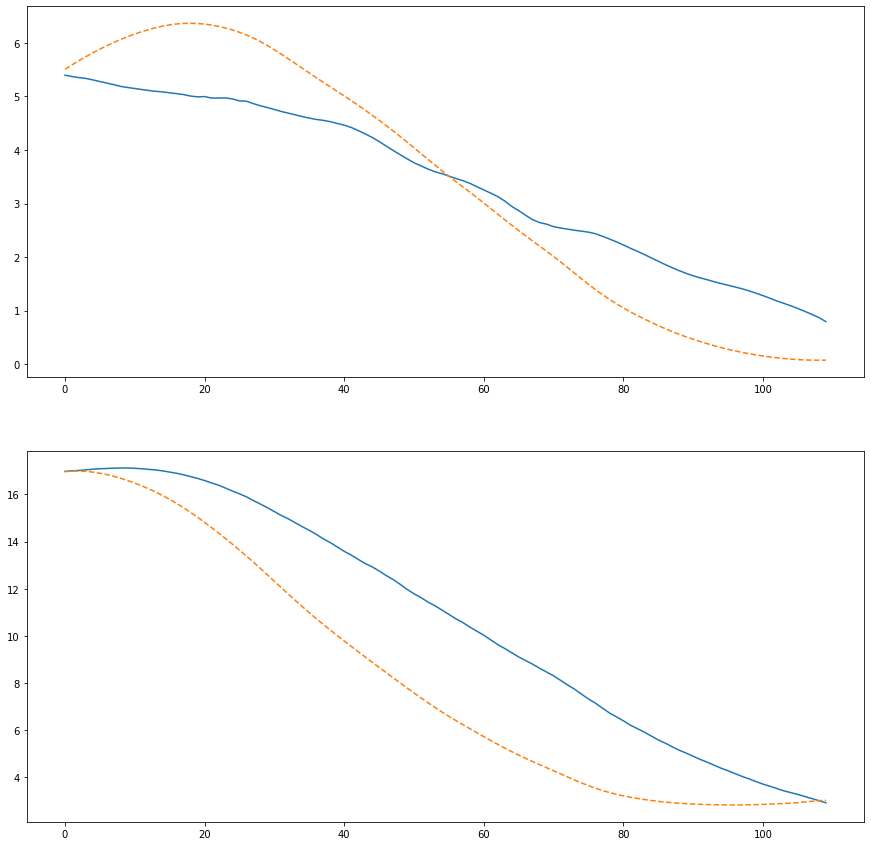

In [76]:
model_names = [ 'transfollower', 'lstm', 'nn']
data_names = ['SH']

calibration_res = sio.loadmat('IDM/IDM_SH_transformer.mat')
para = calibration_res['bestX'][0]

for data_name in data_names:
    _,_, IDM_loader = get_data(data_name = data_name, shuffle = False, batch_size = 1)
    
    batch_num = 1
    fig, axs = plt.subplots(2, figsize = (15, 15))
    
    for i, item in enumerate(IDM_loader):
        if i == batch_num:
            event = item['all'][0]
            svSpd_obs, spacing_obs, lvSpd_obs, svSpd_sim, spacing_sim = IDM_sim(para, event, context = settings.SEQ_LEN)
            break
            
#     axs[0].plot(lvSpd_obs, label = 'Observed LV')
    axs[0].plot(svSpd_obs, label = 'Observed SV')
    axs[0].plot(svSpd_sim, '--', label = 'IDM')
    
    axs[1].plot(spacing_obs, label = 'Observed spacing')
    axs[1].plot(spacing_sim, '--', label = 'IDM')
    
    for model_name in model_names:
#         assert svSpd == svSpd_obs
        speed_error, spacing_error, lvSpd, spacing, svSpd, spacing_sim, svSpd_sim = val(model_name, data_name, batch_num)
        axs[0].plot(svSpd_sim, '--', label = model_name)
        axs[1].plot(spacing_sim, '--', label = model_name)
        
    axs[0].legend()
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Speed (m/s)')
    
    axs[1].legend()
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Spacing (m)')
    

# plotly

In [102]:
model_names = [ 'transfollower', 'lstm', 'nn']
data_names = ['SH']

calibration_res = sio.loadmat('IDM/IDM_SH_transformer.mat')
para = calibration_res['bestX'][0]

WD = 3
OPACITY = 1

name_dict = {
    'nn': 'NN',
    'transfollower':'Transfollower',
    'lstm':'LSTM'    
}

dash_mode = {
    'nn':'dot',
    'transfollower':'dashdot',
    'lstm':'dash'
}

for data_name in data_names:
    _,_, IDM_loader = get_data(data_name = data_name, shuffle = False, batch_size = 1)
    
    # 1, 34 are good
    for batch_num in [1,34]:
    
        fig_speed = go.Figure()
        fig_spacing = go.Figure()

        for i, item in enumerate(IDM_loader):
            if i == batch_num:
                event = item['all'][0]
                svSpd_obs, spacing_obs, lvSpd_obs, svSpd_sim, spacing_sim = IDM_sim(para, event, context = settings.SEQ_LEN)
                IDM_spd_error = criterion(torch.tensor(svSpd_obs), torch.tensor(svSpd_sim)) 
                IDM_spacing_error = criterion(torch.tensor(spacing_obs), torch.tensor(spacing_sim))
                break

        time = (np.arange(len(svSpd_obs)) + settings.SEQ_LEN)/10  

        fig_speed.add_trace(go.Scatter(x = time, y = svSpd_obs, 
                                       name = 'Observed', mode = 'lines', 
                                       opacity = OPACITY, line = dict(width = WD))) 

        fig_speed.add_trace(go.Scatter(x = time, y = svSpd_sim, opacity = OPACITY,
                                       name = f'IDM, MSE: {np.round(IDM_spd_error.item(),2)}', 
                                       mode ='lines+markers',
                                       marker = dict(size = 3), line = dict(dash ='dash', width = WD-1) ))

        fig_spacing.add_trace(go.Scatter(x = time, y = spacing_obs, 
                                       name = 'Observed', mode = 'lines', 
                                        opacity = OPACITY, line = dict(width =WD))) 
        fig_spacing.add_trace(go.Scatter(x = time, y = spacing_sim, opacity = OPACITY,
                                       name = f'IDM, MSE: {np.round(IDM_spacing_error.item(),2)}',
                                         mode ='lines+markers',
                                        marker = dict(size = 3), line = dict(dash = 'dash', width = WD -1)))

        for model_name in model_names:
            speed_error, spacing_error, lvSpd, spacing, svSpd, spacing_sim, svSpd_sim = val(model_name, data_name, batch_num)
            fig_speed.add_trace(go.Scatter(x = time, y = svSpd_sim, opacity = OPACITY,
                                       name = f'{name_dict[model_name]}, MSE: {np.round(speed_error,2)}', 
                                           line = dict(width = WD if model_name =='transfollower' else WD-1,
                                                       dash = dash_mode[model_name])))
            fig_spacing.add_trace(go.Scatter(x = time, y = spacing_sim, opacity = OPACITY,
                                       name = f'{name_dict[model_name]}, MSE: {np.round(spacing_error,2)}', 
                                             line = dict(width = WD if model_name =='transfollower' else WD-1, 
                                                         dash = dash_mode[model_name])))

        fig_speed.update_xaxes(title = dict(text = 'Time (s)'))
        fig_speed.update_yaxes(title = dict(text = 'Following Vehilce Speed (m/s)'))

        fig_spacing.update_xaxes(title = dict(text = 'Time (s)'))
        fig_spacing.update_yaxes(title = dict(text = 'Inter Vehilce Spacing (m)'))
        
        
        fig_speed.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0
        ))
        fig_speed.update_layout(
            margin=dict(l=0, r= 0, t = 0, b=0),
            width = 800, height = 400
        )
        
        fig_spacing.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0
        ))
        fig_spacing.update_layout(
            margin=dict(l=0, r= 0, t = 0, b=0),
            width = 800, height = 400
        )
        
        fig_speed.show()
        fig_spacing.show()
        
        fig_speed.write_image(f'figures/{batch_num}_speed.pdf')
        fig_spacing.write_image(f'figures/{batch_num}_spacing.pdf')

/home/starlab/anaconda3/envs/meixin_rl/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/starlab/anaconda3/envs/meixin_rl/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

